In [1]:
#Our goal here is to identify different types of wafer map failure pattern automatically, so that its construction can
#be improved, by increasing the accuracy of the manufacturing process.

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import os
from os.path import join

import numpy as np
import pandas as pd
import scipy.io as sio

import tensorflow as tf
import keras
from keras import layers, Input, models
#from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

wafer_bins=pd.read_pickle("../input/wm811k-wafer-map/LSWMD.pkl")
wafer_bins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [2]:
#We can see that we will be able to use 811457 wafermaps for the deep learning to detect all detections

#After having looked in the dataset, we can see that there is several types of mapping (9 precisely), and data
#either for the training or the test. So let's rearrange these information.

wafer_bins['failureNum']=wafer_bins.failureType
wafer_bins['trainTestNum']=wafer_bins.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
wafer_bins=wafer_bins.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
wafer_bins['waferMapDim']=wafer_bins.waferMap.apply(find_dim)

wafer_bins.sample(10)

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,failureNum,trainTestNum,waferMapDim
113025,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...",533.0,lot7586,11.0,[],[],[],[],"(26, 26)"
265024,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3532.0,lot16413,5.0,[],[],[],[],"(64, 71)"
50673,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",776.0,lot4143,10.0,[],[],[],[],"(30, 34)"
79141,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",1187.0,lot5765,11.0,[],[],[],[],"(51, 30)"
254587,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4612.0,lot15744,3.0,[],[],[],[],"(81, 73)"
518112,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 2,...",515.0,lot32401,5.0,[],[],[],[],"(25, 27)"
147707,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",14116.0,lot9458,10.0,[],[],[],[],"(212, 84)"
754512,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...",503.0,lot45226,17.0,[[Training]],[[none]],8,0,"(27, 25)"
477621,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1513.0,lot29523,10.0,[],[],[],[],"(49, 39)"
175442,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2393.0,lot11225,10.0,[],[],[],[],"(52, 59)"


In [3]:
#In this document, we have to choose which wafermaps we need. Because, there are many in which we can see that the 
#labels have a pattern (we need these ones), and some label without a pattern.

#From now on, I will call the variable wafer_bins wb.
wb=wafer_bins

#Our database will be reduced for sure, so let's see how much it will be.

wb_withlabel = wb[(wb['failureNum']>=0) & (wb['failureNum']<=8)]
wb_withlabel =wb_withlabel.reset_index()
wb_withpattern = wb[(wb['failureNum']>=0) & (wb['failureNum']<=7)]
wb_withpattern = wb_withpattern.reset_index()
wb_nonpattern = wb[(wb['failureNum']==8)]
print(wb_withlabel.shape[0], wb_withpattern.shape[0], wb_nonpattern.shape[0])

172950 25519 147431


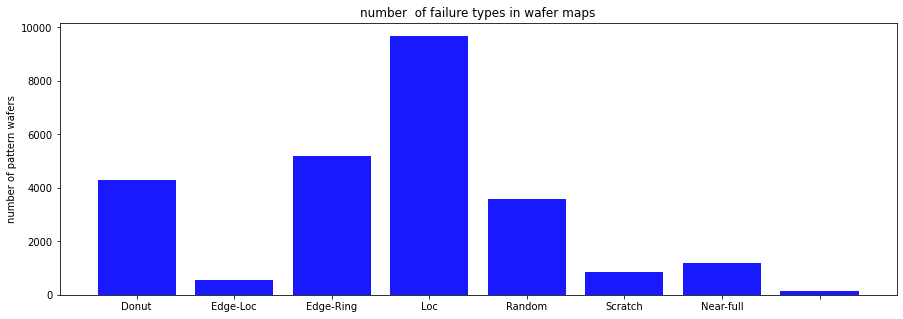

In [4]:
#As we can see, we only choose those we need, so we just don't study the None failure types nor the non-labelled
#wafer maps. So we just keep the 25519 wafer maps we need, it really reduces the amount of work. But we still have to
#remove the null label. And from now on, we will work with this reduced database.

wb=wb_withpattern
for i in range(len(wb)):
    if len(wb.iloc[i,:]['failureType']) == 0:
        wb.remove(wb[i])

#Let's show how is organized the distribution of the Failure Types:

%matplotlib inline

fig = plt.figure(figsize=(15, 5))
axe=plt.subplot(1,1,1)

uni_pattern=np.unique(wb.failureNum, return_counts=True)
labels = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
axe.bar(uni_pattern[0],uni_pattern[1], color='blue', align='center', alpha=0.9)
axe.set_title("number  of failure types in wafer maps")
axe.set_ylabel("number of pattern wafers")
axe.set_xticklabels(labels)

plt.show()

In [5]:
#Now we have all the Failure Types we want, we will be able to start the deep learning, and as this problem is
#sequential, we will use the sequence to sequence model.

#So now, let's settle the parameters of the encoder part.

#Our encoder will be composed with a stack of several convolutional neutral networks (CNNs) units where each accepts a 
#single element of the input sequence, collects information for that element and propagates it forward.

#But first, we need a precise shape for the wafer maps we will use, it has to be a square, so we have to choose a
#shape, and then we have to create a list of images which are in this shape, and their associated failure types

sub_wb = wb.loc[wb['waferMapDim'] == (26, 26)]

Imlist = np.ones((1, 26, 26))
label = []

for i in range(len(sub_wb)):
    Imlist = np.concatenate((Imlist, sub_wb.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_wb.iloc[i,:]['failureType'][0][0])
    
#The first elemet in Imlist is just composed with ones, so it isn't intersesting, let's remove it
Imlist=Imlist[1:]
label=np.array(label).reshape((-1,1)) #Column of labels
print(Imlist[756][0][10], Imlist[756][0][9], Imlist[756][0][11])
#We have all the values of the pixels: 0.0 is for the exterior ofthe wafer map, 2.0 is for the local impure pixel, and 
#1.0 is for a pure pixel of the wafer map

print(np.shape(Imlist),np.shape(label))

2.0 0.0 1.0
(877, 26, 26) (877, 1)


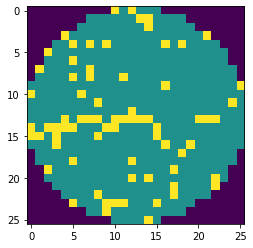

label assiociated :  ['Scratch']
Center : 90
Donut : 1
Edge-Loc : 296
Edge-Ring : 31
Loc : 297
Near-full : 16
Random : 74
Scratch : 72


In [6]:
#This not the most important part, but we can plot the defected wafer map, if we want to. The 511th data for example
plt.imshow(Imlist[756])
plt.show()
print("label assiociated : ", label[756])
#Also we can see how much defect labels in this dataset

for l in np.unique(label) :
    print('{} : {}'.format(l, len(label[label==l])))

In [7]:
Imlist=Imlist.reshape((-1,26,26,1))
#With that, each pixel of each image is separated and we will be able to use them separately in order to process the 
#deep learning

new_Imlist = np.zeros((len(Imlist), 26, 26, 3))

for w in range(len(Imlist)):
    for i in range(26):
        for j in range(26):
            new_Imlist[w, i, j, int(Imlist[w, i, j])] = 1

#In order to process to the deep learning, we have to use data compsed by 1 only. So we have to transform these
#0.0, 1.0 or 2.0 in a sequence of 1 and 0. So with these loops, we can say:
    #for 0.0: [1,0,0]
    #for 1.0: [0,1,0]
    #for 2.0: [0,0,1]
#And now we can settle our process of deep learning

In [8]:
#We have to prepare some data for the training and the test, and define the encoder and decoder.

epoch=30
batch_size=877

input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)
#Relu activation function, in this case, just keep the values we are convoluting, and it let us do the same for the
#output tensor created.

#Now that the encoder is settled, we have to code the latent vector, which is the last part of the encoder, and it aims 
#to encapsulate the information for all input elements in order to help the decoder make accurate predictions.
#It acts as the initial hidden state of the decoder part of the model.

#Only the highest value of a region is kept.Max pooling is akeeping the most activated pixels (ones with the highest 
#values) and discards the rest.

latent_vector = layers.MaxPool2D()(encode)

encoder = models.Model(input_tensor, latent_vector)

#And now the decoder, and then connecting all the layers, to finally have the predicted output tensor. A stack of 
#several recurrent units where each predicts an outputEach recurrent unit accepts a hidden state from the previous 
#unit and produces and output as well as its own hidden state.

decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu') #It is the transposed 
#convolution layer, so the inverse step as the encoder
decode_layer_2 = layers.UpSampling2D() #Repeats the rows and columns of the data by size[0] and size[1] respectively.
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

#After having regarding the shape I needed for the start of the decoder, I have to define it.
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

#Now we have all the model, let's prepare the dataset, with normal wafers, and noised wafers, so that we will have some 
#data to make the machine predict their label

encoded_Im = encoder.predict(new_Imlist)
noised_encoded_Im = encoded_Im + np.random.normal(loc=0, scale=0.1, size = (len(encoded_Im), 13, 13, 64))


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

In [9]:
#When you train a deep learning model, what you’re really doing is tuning its parameters such that it can map a 
#particular input (say, an image) to some output (a label). Our optimization goal is to chase that sweet spot where our 
#model’s loss is low, which happens when your parameters are tuned in the right way.

#So, to get more data, we just need to make minor alterations to our existing dataset. Minor changes such as flips or 
#translations or rotations. Our neural network would think these are distinct images anyway.

#So here is our augmentation function

def gen_data(wafer, label):
    encoded_x = encoder.predict(wafer)
    
    gen_x = np.zeros((1, 26, 26, 3)) # Dummy array for collecting noised wafer
    
    for i in range((1500//len(wafer)) + 1): # Make wafer until total of wafer to 1500
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    
    gen_y = np.full((len(gen_x), 1), label) # Also make label vector with same length
    
    return gen_x[1:], gen_y[1:]  # Return date without 1st dummy data.

#And we can apply this function to our dataset to have it full of noised wafer maps

for l in np.unique(label):
    gen_x, gen_y = gen_data(new_Imlist[np.where(label==l)[0]], l)
    new_Imlist = np.concatenate((new_Imlist, gen_x), axis=0)
    label = np.concatenate((label, gen_y))

In [10]:
#Now we can see the shape of our lists, just to now how big is our dataset
for l in np.unique(label) :
    print('{} : {}'.format(l, len(label[label==l])))
print(np.shape(new_Imlist), np.shape(label))

Center : 1620
Donut : 1502
Edge-Loc : 2072
Edge-Ring : 1550
Loc : 2079
Near-full : 1520
Random : 1628
Scratch : 1584
(13555, 26, 26, 3) (13555, 1)


In [11]:
#In order to process the test, we need a matrix of labels
for i, l in enumerate(np.unique(label)):
    label[label==l] = i
    
label = tf.keras.utils.to_categorical(label)

#Now we know this information, we can lower the heavyness of the dataset, because it is too huge
new_IMLIST=new_Imlist[0:13000]
new_LABEL=label[0:13000]
test_Imlist=new_Imlist[13001:13554]
test_label=label[13001:13554]
print(np.shape(new_LABEL))

(13000, 8)


In [12]:
#We have to split our slighter dataset in order to process the test
im_train, im_test, label_train, label_test = train_test_split(new_IMLIST, new_LABEL, test_size=0.33, random_state=2019)
print(np.shape(im_train),np.shape(im_test),np.shape(label_train),np.shape(label_test))

(8710, 26, 26, 3) (4290, 26, 26, 3) (8710, 8) (4290, 8)


In [13]:
#Let's now create the real model we will use for the CNN test
def create_model():
    input_shape = (26, 26, 3)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(8, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

In [14]:
model =KerasClassifier(build_fn=create_model, epochs=30, batch_size=877, verbose=2) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
results = cross_val_score(model, im_train, label_train, cv=kfold)
print(results)
print("training accuracy = ", np.mean(results))

Epoch 1/30
7/7 - 28s - loss: 3.3495 - accuracy: 0.1371
Epoch 2/30
7/7 - 27s - loss: 2.0598 - accuracy: 0.1573
Epoch 3/30
7/7 - 27s - loss: 2.0250 - accuracy: 0.1703
Epoch 4/30
7/7 - 27s - loss: 1.9958 - accuracy: 0.1843
Epoch 5/30
7/7 - 26s - loss: 1.9790 - accuracy: 0.1845
Epoch 6/30
7/7 - 26s - loss: 1.9579 - accuracy: 0.1914
Epoch 7/30
7/7 - 28s - loss: 1.9187 - accuracy: 0.2220
Epoch 8/30
7/7 - 26s - loss: 1.8498 - accuracy: 0.3130
Epoch 9/30
7/7 - 26s - loss: 1.6949 - accuracy: 0.3603
Epoch 10/30
7/7 - 26s - loss: 1.4953 - accuracy: 0.4327
Epoch 11/30
7/7 - 26s - loss: 1.4488 - accuracy: 0.4263
Epoch 12/30
7/7 - 26s - loss: 1.3645 - accuracy: 0.4473
Epoch 13/30
7/7 - 27s - loss: 1.3022 - accuracy: 0.4835
Epoch 14/30
7/7 - 26s - loss: 1.2676 - accuracy: 0.4900
Epoch 15/30
7/7 - 26s - loss: 1.2125 - accuracy: 0.5222
Epoch 16/30
7/7 - 27s - loss: 1.3230 - accuracy: 0.4967
Epoch 17/30
7/7 - 27s - loss: 1.3997 - accuracy: 0.4537
Epoch 18/30
7/7 - 26s - loss: 1.2689 - accuracy: 0.5005
E

In [15]:
#Now we have done the training is done, let's validate the learning with the test dataset
history = model.fit(im_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(im_test, label_test))

Epoch 1/30
10/10 - 47s - loss: 2.4662 - accuracy: 0.1470 - val_loss: 2.0699 - val_accuracy: 0.1711
Epoch 2/30
10/10 - 46s - loss: 2.0589 - accuracy: 0.1544 - val_loss: 2.0326 - val_accuracy: 0.1716
Epoch 3/30
10/10 - 46s - loss: 2.0266 - accuracy: 0.1530 - val_loss: 1.9986 - val_accuracy: 0.1716
Epoch 4/30
10/10 - 46s - loss: 1.9766 - accuracy: 0.2325 - val_loss: 1.9308 - val_accuracy: 0.1725
Epoch 5/30
10/10 - 46s - loss: 1.8809 - accuracy: 0.3163 - val_loss: 1.7766 - val_accuracy: 0.3937
Epoch 6/30
10/10 - 46s - loss: 1.6998 - accuracy: 0.3869 - val_loss: 1.5708 - val_accuracy: 0.4107
Epoch 7/30
10/10 - 46s - loss: 1.5874 - accuracy: 0.3605 - val_loss: 1.6803 - val_accuracy: 0.3089
Epoch 8/30
10/10 - 45s - loss: 1.4429 - accuracy: 0.4574 - val_loss: 1.3837 - val_accuracy: 0.4809
Epoch 9/30
10/10 - 47s - loss: 1.2856 - accuracy: 0.5243 - val_loss: 1.2520 - val_accuracy: 0.5543
Epoch 10/30
10/10 - 46s - loss: 1.1662 - accuracy: 0.5731 - val_loss: 1.1791 - val_accuracy: 0.5429
Epoch 11/

In [16]:
#And finally let's see what is the testing accuracy

score = model.score(im_test, label_test)
print('Testing Accuracy:',score)

5/5 - 6s - loss: 0.8097 - accuracy: 0.6949
Testing Accuracy: 0.6948717832565308


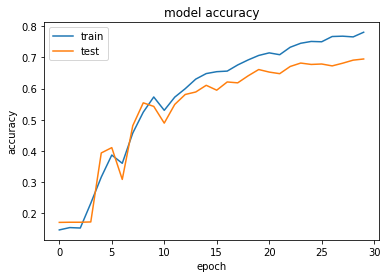

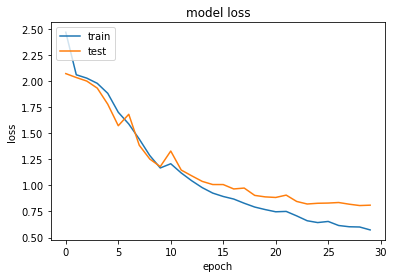

In [17]:
#Let's now plot the differnces in the losses and the accuracies between the training and the test
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()